# N-BEATS 

First Paper: https://arxiv.org/pdf/1905.10437.pdf

In this article, I will first explain N-BEATS using more intuition and less equations. Then, I will apply it, using Python, on a real-life forecasting scenario and evaluate its performance.

## Understanding N-BEATS
N-BEATS stands for **Neural Basis Expansion Analyis** for Interpretable Time Series.

As the name suggests, the core functionality of N-BEATS lies in **basis expansion**. So before diving right into the model’s architecture, let’s first clarify what basis expansion is.

### Basis expansion
Basis expansion is a method of augmenting our data. It is often done in order to model non-linear relationships.

A common basis expansion is **polynomial basis expansion**. For example, suppose that we have only two features, as shown below.

$$[x_1, x_2]$$
A set of two features. Image by the author.

Then, if we do a polynomial basis expansion of degree 2, our feature set becomes:

$$[x_1,x_2,x_1^2,x_2^2]$$

Result of a polynomial basis expansion of degree 2 on the feature set. We notice that we simply add the square of the existing features. This allows us to fit a quadratic model, so that we can capture non-linear relationships.

<figure style="width: 600px; text-align: center;">
  <img src="img/nbeats.png" alt="Time-LLM">
  <figcaption style="font-size: 12px;">Fig: Visualizing the predictions of Time-LLM using GPT-2. Image by the author.</figcaption>
</figure>


As you can see, the result of the polynomial basis expansion of degree 2 is that we simply added the square of our features to the feature set. 

Therefore, this means that we can now fit a second-degree polynomial model to our data, effectively modeling non-linear relationships!

Looking at the figure above, we can see that when we do not perform basis expansion, we only a have a straight line, as shown on the left. However, on the right, once we performed a polynomial basis expansion of degree 2, we then get a quadratic model that if a much better fit to our data.

Of course, basis expansion is not limited to polynomials; we can do logarithms, powers, etc. The main takeaway is that basis expansion is used to augment our set of features in order to model non-linear relationships.

In the case of N-BEATS, the basis expansion is not set by us. Instead, the model is trained to find the best basis expansion method in order to fit the data and make predictions. In other words, we let the neural network find the best data augmentation method to fit our dataset, hence the name: neural basis expansion.

Now that we are comfortable with the concept of basis expansion, let’s move on to the architecture of the model.

## The architecture of N-BEATS

There were three key principles in designing the architecture of N-BEATS:

- The base architecture should be simple and generic, yet expressive
- The architecture should not rely on time-series-specific components (like trend or seasonality)
- The architecture can be extendable to make the output interpretable

Following these considerations, the creators of N-BEATS designed the model like this:

<figure style="width: 600px; text-align: center;">
  <img src="img/nbeats1.png" alt="Time-LLM">
  <figcaption style="font-size: 12px;">Fig: Architecture of N-BEATS. Image by B. Oreshkin, D. Carpov, N.Chapados and Y. Bengio from N-BEATS: Neural Basis Expansion Analyis For Interpretable Time Series Forecasting</figcaption>
</figure>

There is a lot of information to absorb from the picture above, so let’s go step by step.

Looking a the top right of the picture, we can see a time series being split between a lookback period and a forecast period. The lookback period is fed to the model, while the forecast period contains the actual values that allows us to evaluate the predictions of our model.

Notice that the input sequence has a length that is a multiple of the forecast length. Therefore, for a forecast horizon of length H, the input sequence should have a length ranging from 2H to 6H typically.

Then, going from right to left in the figure above, we see that N-BEATS (yellow rectangle on the right) is made of layered stacks, which are themselves made of blocks (middle orange rectangle), and we can see how each block is constructed (blue rectangle on the left).

We can see that a block is made of four fully connected layers. This network produces two things: a forecast and a backcast. The forecast is simply a prediction of future values, whereas a backcast is a value coming from the model that we can immediately compare to the input sequence and evaluate the fit of the model.

Note that it is at the block level that the network finds the expansion coefficients (denoted as theta in the diagram) and then the basis expansion is performed (denoted as the function g in the diagram).

In this architecture, only the first block gets the actual input sequence. The following block then gets the residuals coming from the first block. This means that only the information that was not captured by the first block is passed on the next. 

This results in a sequential treatment of the input sequence where each block is trying to capture information that was missed by the previous one.

Combining different blocks together then gives us a stack, which outputs a partial prediction. We then add more stacks to the model, and each stack will output its partial prediction. The combination of each partial prediction then results in the final forecast.

### Making the model interpretable
At this point, we understand the inner workings of N-BEATS, but how exactly is this model interpretable?

Right now, it is not. The function responsible for the basis expansion, denoted as g in the diagram, is a learnable function. This means that we let the neural network design a problem-specific function to get the best results.

However, it is possible to constrain the function g to something that we can understand. In time series forecasting, we often use elements like trend and seasonality to inform our forecasts, and we can force the function g to express a trend component or a seasonality component. 

To represent the trend, we use a polynomial basis. To represent seasonality, we use a Fourier basis.

Therefore, in the interpretable version of the architecture, we force the model to have only two stacks: one stack specializes in forecasting a trend component, and the other specializes in forecasting a seasonal component. Then, each prediction is combined to form a final output.

The difference between the generic and interpretable architecture is shown below.

<figure style="width: 600px; text-align: center;">
  <img src="img/nbeat03.jpg" alt="Time-LLM">
  <figcaption style="font-size: 12px;">Fig: Difference between the generic and interpretable architecture for N-BEATS. On the left, the generic architecture has as many stacks as we want, but we lose interpretability. On the right, we force the model to have only two stacks, at the cost of a possible lower performance. Image by the author.</figcaption>
</figure>

### Wrapping up
To summarize, N-BEATS has two configurations. The generic configuration allows the model to find the optimal basis expansion that is specific to our problem. The interpretable configuration forces a stack to specialize in forecasting the trend, and the other stack the seasonality.

The residual connections in the network allows to the model to capture information that was missed by previous blocks. Finally, the combination of the partial prediction of each stack is combined to obtain the final prediction.

I hope I managed to make N-BEATS fairly easy to understand. Now, let’s move on to actually applying N-BEATS in a forecasting project using Python.

## Forecasting with N-BEATS
We are now ready to apply the N-BEATS model in a forecasting project. Here, we will predict the hourly Interstate 94 Westbound traffic volume.We will use the Darts library for this project, as it makes it very easy to apply state-of-the-art models, like N-BEATS, in time series applications. 

All code is in Python and you can grab the full source code, as well as the dataset, on GitHub.

Let’s go!

### Read the data
Of course, every project starts off with importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [4]:
df = pd.read_csv('data/daily_traffic.csv')

df.head()

,date_time,traffic_volume
0,9/29/2016 17:00,5551.0
1,9/29/2016 18:00,4132.0
2,9/29/2016 19:00,3435.0
3,9/29/2016 20:00,2765.0
4,9/29/2016 21:00,2443.0


<Axes: xlabel='date_time'>

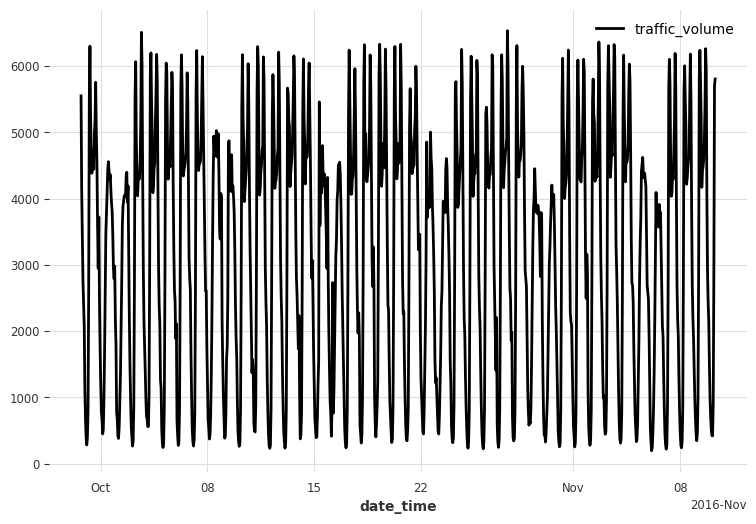

In [6]:
series = TimeSeries.from_dataframe(df, time_col='date_time')

series.plot()

In [16]:
# series.plot()
# plt.xlim('9/29/2016 17:00', '10/16/2016 9:00');

In [8]:
from darts.utils.statistics import check_seasonality

is_daily_seasonal, daily_period = check_seasonality(series, m=24, max_lag=400, alpha=0.05)
is_weekly_seasonal, weekly_period = check_seasonality(series, m=168, max_lag=400, alpha=0.05)

print(f'Daily seasonality: {is_daily_seasonal} - period = {daily_period}')
print(f'Weekly seasonality: {is_weekly_seasonal} - period = {weekly_period}')

Daily seasonality: True - period = 24
Weekly seasonality: True - period = 168


<Axes: xlabel='date_time'>

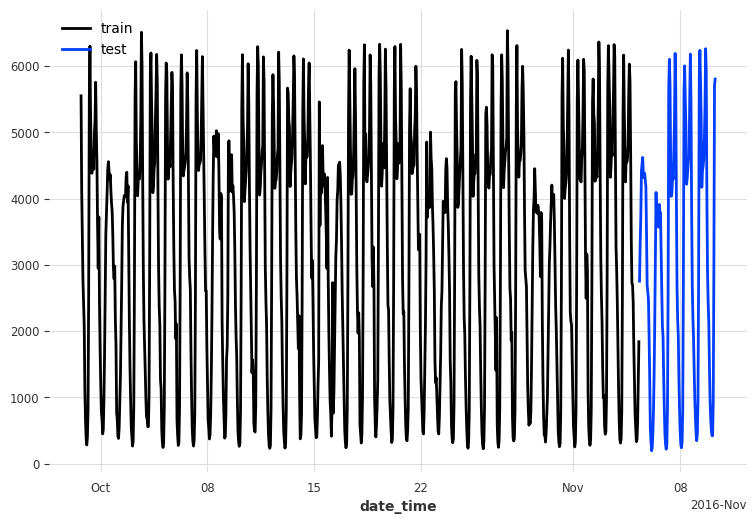

In [9]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [10]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

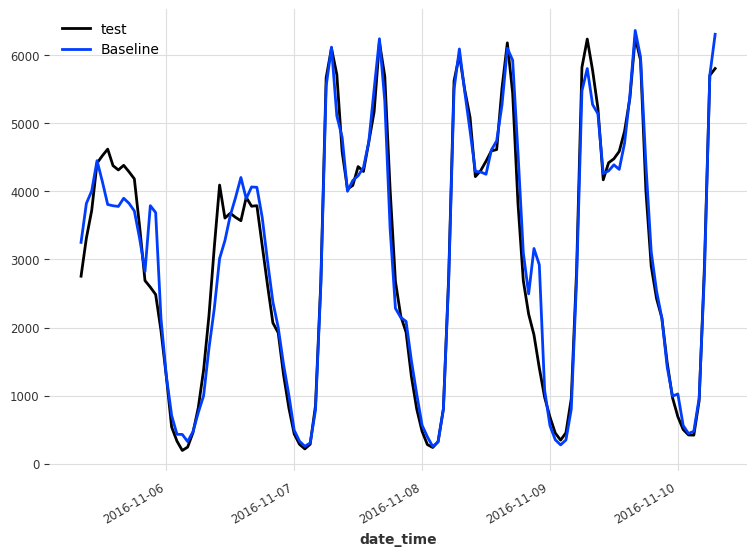

In [9]:
test.plot(label='test')
pred_naive.plot(label='Baseline')

In [11]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

249.09166666666667


## N-BEATS without covariates 

We finally reached the point where we apply N-BEATS to our problem.

We know that we have two seasonal periods, but let’s try N-BEATS without giving it that information. We will let the model work on its own, before we help it out.

We start off by importing N-BEATS and a data scaler to speed up the training of the model. We then scale our data between 1 and 0. Note that we fit the scaler on the training set only, because the model is not supposed to have information coming from the test set. Then, we initialize the N-BEATS model. The input length will contain a full week of data, and the model will output 24h of data. In this case, we use the generic architecture. Then, we simply fit the model on the scaled training set.

In [12]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nbeats = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats.fit(
    scaled_train,
    epochs=50
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A1000 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estima

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=42)

Once the model is done training, we can forecast over the horizon of the test set. Of course, the predictions are scaled as well, so we need to reverse the transformation.

In [13]:
scaled_pred_nbeats = nbeats.predict(n=120)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [14]:
mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)

292.39770358339786


This gives a MAE of 292, which is higher than the baseline. This means that N-BEATS does not perform better than our naive predictions.

So, let’s add covariates to the model to see if we can improve its performance.

## N-BEATS with covariates 

Earlier in the article, we determined that there are two seasonal periods that are significant in our time series. We can encode that information and pass it to the model as covariates. 

In other words, we add two features to the model that tells it where we are during the day and during the week. That way, the model learn that weekends have lower traffic volume, and that traffic is lower at night than during the day.

Darts conveniently comes with a an easy to achieve this using datetime_attribute_timeseries.

In [23]:
series.columns

Index(['traffic_volume'], dtype='object', name='component')

In [24]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = concatenate(
    [dt_attr(series.time_index, 'day', dtype=np.float32), dt_attr(series.time_index, 'week', dtype=np.float32)],
    axis='component'
)

<Axes: xlabel='date_time'>

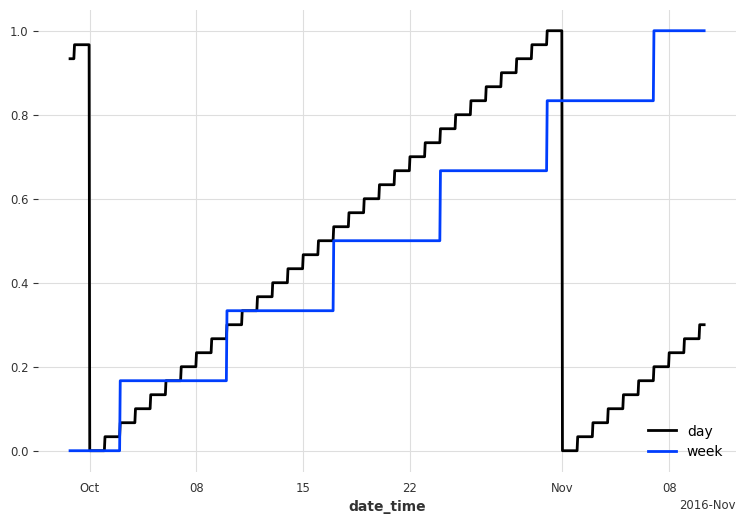

In [26]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_scaled_cov = scaled_cov[:-120], scaled_cov[-120:]

scaled_cov.plot()

In [27]:
nbeats_cov = NBEATSModel(
    input_chunk_length=168, 
    output_chunk_length=24,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=50
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 M
---------------------------------------------------
10.0 M    Trainable params
4.3 K     Non-trainable params
10.0 M    Total params
39.922    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=42)

In [28]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=120)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [29]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

print(mae_nbeats_cov)

274.5406254464251


This gives us a MAE of 274.54. This is better than not using covariates, but still worse than the baseline model.

<Axes: xlabel='date_time'>

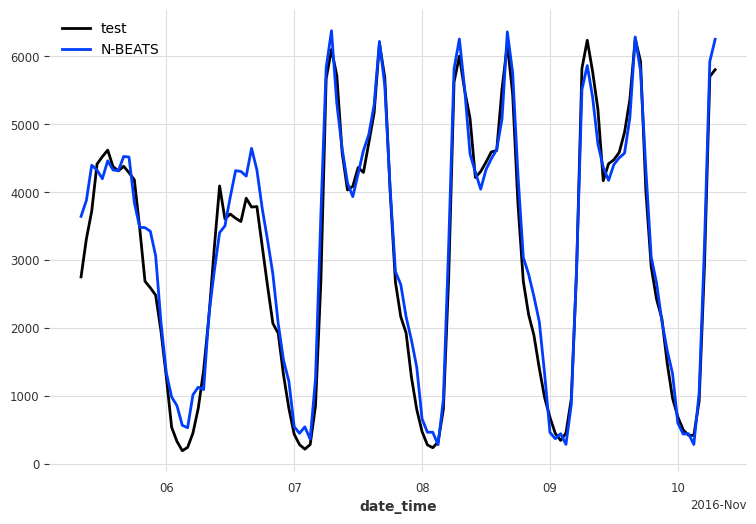

In [30]:
test.plot(label='test')
pred_nbeats.plot(label='N-BEATS')

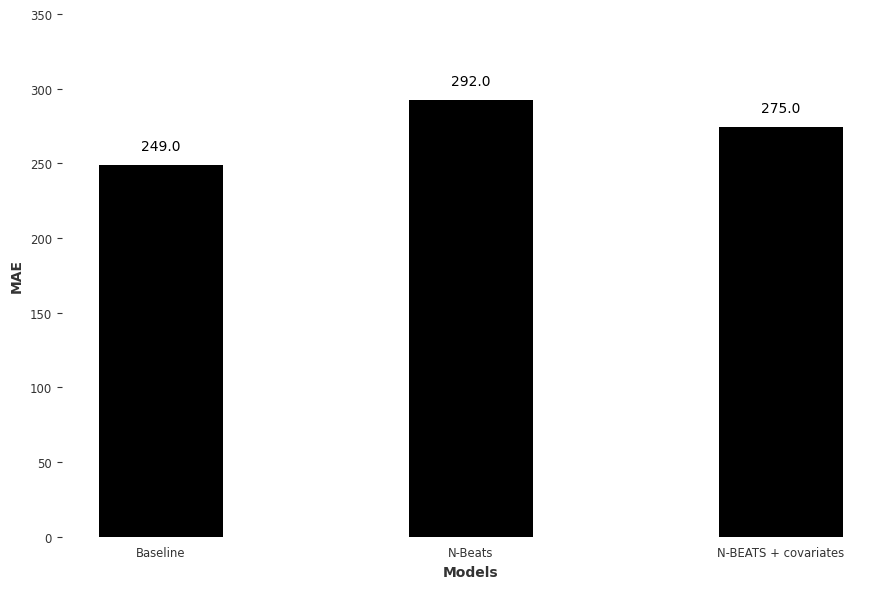

In [31]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-Beats', 'N-BEATS + covariates']
y = [naive_mae, mae_nbeats, mae_nbeats_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 350)
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value,0)), ha='center')

plt.tight_layout()

Mean absolute error (MAE) of the forecasts of each model. We see that adding covariates helped the model, but its performance is still worse than the baseline. Image by the author.

## A note on the results

The results obtained are less than exciting, but take them with a grain salt. Keep in mind that we are working with a fairly small and simple dataset. It might be that the sample I took from the full dataset is simply repetitive by nature, which explains why the baseline is so good.

Nevertheless, you now know how to implement N-BEATS in a forecasting project and you can also appreciate the importance of having a baseline model.

## Conclusion
N-BEATS is a state-of-the-art deep learning model for time series forecasting that relies on the principle of basis expansion. The model can learn problem-specific functions for basis expansion, or we can constrain them to have interpretable outputs.

I hope you enjoyed the read and that you learned something new!